Planet and Comet detection filter impltemented to remove planetary transients and cometary transients that have a signature of a bright straight line. In this case, we focus on lines that have sufficient evidence to be considered to be horizontally detected. 
This filter is applied to LASCO C2 and C3 images.

Using Probabilistic Hough Transform.

https://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html

In [1]:
import numpy as np
from skimage.feature import canny
from skimage.transform import probabilistic_hough_line
from skimage.feature import blob_log, blob_dog, blob_doh
from skimage.draw import line

from astropy.io import fits

import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline

/home/carl/anaconda3/envs/SunDL/lib/python3.6/site-packages/matplotlib/__init__.py:1003: UserWarning: Duplicate key in file "/home/carl/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))


In [2]:
def readfits(filename):
    hdrs = []
    try:
        ft = fits.open(filename, memmap=False)
        for i in range(len(ft)):
            hdrs.append(ft[i].header)
            hdr = ft[i].header
            data = ft[i].data
            print(np.shape(data))
            
        axis1 = hdr['naxis1']
        axis2 = hdr['naxis2']
        axisnum = hdr['naxis']
        ft.close()
        
    except ValueError:
        axis1 = 1
        axis2 = 2
        axisnum = 3
        data = None
        hdrs = None
            
    return axis1, axis2, data, hdrs, axisnum

In [3]:
local_path = '/home/carl/Downloads/' #'LOCAL_PATH/Planet_Comet_examples/'
planet_comet_object = 'comet_ASAS32130223.fts' #a FITS file in the Planet_Comet_examples folder

local_path_to_planet_comet = f'{local_path}{planet_comet_object}'

In [4]:
axis1, axis2, data_obj, hdrs, axisnum = readfits(local_path_to_planet_comet)

(1024, 1024)


In [7]:
data_log10 = np.log10(data_obj)

edges = canny(data_log10)
lines = probabilistic_hough_line(edges, threshold=80, line_length=5, line_gap=0, theta=np.array([-np.pi/2, np.pi/2]), seed=1)

print('lines:',lines)
print('np.shape(lines):', np.shape(lines))

lines: [((780, 1022), (257, 1022)), ((942, 1022), (914, 1022)), ((682, 1), (355, 1)), ((382, 599), (344, 599)), ((463, 599), (423, 599)), ((463, 597), (425, 597)), ((384, 597), (345, 597))]
np.shape(lines): (7, 2, 2)


In [8]:
### for C3 will use horizontal detection #for C2 just the line detection (as this is any straight line - good for comets)

horiz_list = []
for line in lines:
    p0, p1 = line
    horiz_list.append(p1[1] - p0[1])
print('len(horiz_list):', len(horiz_list))
ind_horiz_zero = np.where(np.array(horiz_list) == 0)[0]
print('len(ind_horiz_zero):', len(ind_horiz_zero))

len(horiz_list): 7
len(ind_horiz_zero): 7


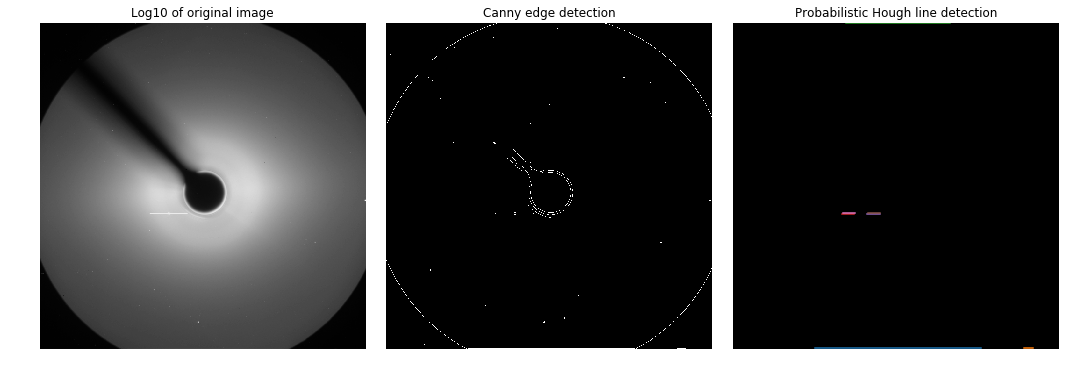

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(data_log10, cmap=cm.gray, origin='lower')
ax[0].set_title('Log10 of original image')

ax[1].imshow(edges, cmap=cm.gray, origin='lower')
ax[1].set_title('Canny edge detection')

ax[2].imshow(edges * 0, cmap=cm.gray, origin='lower')
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, data_log10.shape[1]))
ax[2].set_ylim((data_log10.shape[0], 0))
ax[2].set_title('Probabilistic Hough line detection')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

(128, 128)
np.shape(blobs_log): (117, 3)


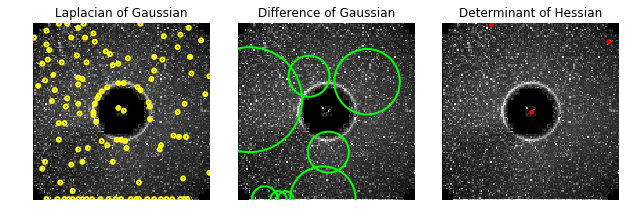

In [32]:
### PATH TO COSMIC RAY SNOW SPECKELED C2 IMAGES

### inspired by https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html ###

local_path_speckled_blob = '/home/carl/Downloads/C2_spike_images_All7synced/'
#'/home/carl/Downloads/C3_spike_images_All7synced/' #'LOCAL_PATH/speckled_blob_examples/'
speckled_C2_or_blob_C3 = 'CR_snow_SOHO_LASCO_C2_20000715134400_128.fits'
#'round_obj_SOHO_LASCO_C3_19990218213525_128.fits' 
local_path_to_C2_speckled_round_obj = f'{local_path_speckled_blob}{speckled_C2_or_blob_C3}'

#'/home/carl/Downloads/C3_spike_images_All7synced/round_obj_SOHO_LASCO_C3_19990218213525_128.fits'

AA, BB, image_gray, CC ,DD = readfits(local_path_to_C2_speckled_round_obj)

blobs_log = blob_log(image_gray,  max_sigma=30, num_sigma=10, threshold=.1)
print('np.shape(blobs_log):', np.shape(blobs_log))

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)

blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian', 'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image_gray, cmap=cm.gray, origin='lower')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()